In [189]:
#Higher-orderMFVI
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.special import psi
import math

LAMBDA = []
MaxELBO = []

def Higher_order_MFVI(theta):
    y = [11, 12, 8, 10, 9, 8, 9, 10, 13, 7] # data
    n = len(y)
    #===========================
    d = 4
    S = 1000  #number of Monte Carlo samples
    beta1_adap_weight = 0.9 # adaptive learning weight
    beta2_adap_weight = 0.9 # adaptive learning weight
    eps0 = 0.1
    #w_adadelta = 0.95 # adaptive learning weight
    #eps_adadelta = 1e-7 # adaptive learning eps

    max_iter = 2000
    patience_max = 20
    tau_threshold = max_iter/2
    t_w = 50
    #hyperparameter
    alpha_hp = 1
    beta_hp = 1
    mu_hp = 0
    sigma2_hp = 10

    lambdaq = np.array([np.mean(y),1.5,2,3]).reshape(1,4)# initial lambdaq
    lambda_best = lambdaq


    #function h_lambda_fun
    def h_lambda_fun(y,mu,sigma2,alpha_hp,beta_hp,mu_hp,sigma2_hp,mu_mu,sigma2_mu,alpha_sigma2,beta_sigma2):
        log_p_mu = -1/2*np.log(2*np.pi)-1/2*np.log(sigma2_hp)-(mu-mu_hp)**2/2/sigma2_hp
        log_p_sigma2 = alpha_hp*np.log(beta_hp)-np.log(math.gamma(alpha_hp))-(alpha_hp+1)*np.log(sigma2)-beta_hp/sigma2
        log_q_mu = -1/2*np.log(2*np.pi)-1/2*np.log(sigma2_mu)-(mu-mu_mu)**2/2/sigma2_mu
        log_q_sigma2 = alpha_sigma2*np.log(beta_sigma2)-np.log(math.gamma(alpha_sigma2))-(alpha_sigma2+1)*np.log(sigma2)-beta_sigma2/sigma2;
        llh = -n/2*np.log(2*np.pi)-n/2*np.log(sigma2)-1/2/sigma2*sum((y-mu)**2)
        return log_p_mu+log_p_sigma2+llh-log_q_mu-log_q_sigma2

    mu_mu = lambdaq[0,0]
    sigma2_mu = lambdaq[0,1]
    alpha_sigma2 = lambdaq[0,2]
    beta_sigma2 = lambdaq[0,3]
    h_lambda = np.zeros((S,1))#  function h_lambda
    grad_log_q_lambda = np.zeros((S,d))
    grad_log_q_times_h = np.zeros((S,d))
    for s in range(S):
        mu = np.random.normal(mu_mu,math.sqrt(sigma2_mu),1)
        sigma2 = 1./np.random.gamma(alpha_sigma2,1/beta_sigma2,1)

        grad_log_q_lambda[s,:]=np.array([(mu-mu_mu)/sigma2_mu,
                                         -1/2/sigma2_mu+(mu-mu_mu)**2/2/sigma2_mu**2,
                                         np.log(beta_sigma2)-psi(alpha_sigma2)-np.log(sigma2),
                                         alpha_sigma2/beta_sigma2-1/sigma2]).reshape(1,4)
        h_lambda[s] = h_lambda_fun(y,mu,sigma2,alpha_hp,beta_hp,mu_hp,sigma2_hp,mu_mu,sigma2_mu,alpha_sigma2,beta_sigma2)    
        grad_log_q_times_h[s,:] = (1-theta)*grad_log_q_lambda[s,:]*h_lambda[s]+ theta*grad_log_q_lambda[s,:]

    cv = np.zeros((1,d))# control variate
    for i in range(d):
        aa = np.cov(grad_log_q_times_h[:,i],grad_log_q_lambda[:,i])
        cv[0,i] = aa[0,1]/aa[1,1]

    grad_LB1= np.mean(grad_log_q_times_h[:,0])
    grad_LB2= np.mean(grad_log_q_times_h[:,1])
    grad_LB3= np.mean(grad_log_q_times_h[:,2])
    grad_LB4= np.mean(grad_log_q_times_h[:,3])
    grad_LB =np.array([grad_LB1,grad_LB2,grad_LB3,grad_LB4]).reshape(1,4)

    #ADAM
    g_adaptive = grad_LB
    v_adaptive = g_adaptive**2
    g_bar_adaptive = g_adaptive
    v_bar_adaptive = v_adaptive

    iter_ = 1
    stop = False
    LB = np.array([-1e3 for i in range(2000)])
    LB_bar = np.array([-1e3 for i in range(2000)])
    patience = 0  

    while not stop:
        mu_mu = lambdaq[0,0]
        sigma2_mu = lambdaq[0,1]
        alpha_sigma2 = lambdaq[0,2]
        beta_sigma2 = lambdaq[0,3]
        h_lambda = np.zeros((S,1))# function h_lambda
        grad_log_q_lambda = np.zeros((S,d))
        grad_log_q_times_h = np.zeros((S,d))
        grad_log_q_times_h_cv = np.zeros((S,d))
        for s in range(S):
            mu = np.random.normal(mu_mu,math.sqrt(sigma2_mu),1)
            sigma2 = 1./np.random.gamma(alpha_sigma2,1/beta_sigma2,1)

            grad_log_q_lambda[s,:]=np.array([(mu-mu_mu)/sigma2_mu,
                                         -1/2/sigma2_mu+(mu-mu_mu)**2/2/sigma2_mu**2,
                                         np.log(beta_sigma2)-psi(alpha_sigma2)-np.log(sigma2),
                                         alpha_sigma2/beta_sigma2-1/sigma2]).reshape(1,4)
            h_lambda[s] = h_lambda_fun(y,mu,sigma2,alpha_hp,beta_hp,mu_hp,sigma2_hp,mu_mu,sigma2_mu,alpha_sigma2,beta_sigma2)    
            grad_log_q_times_h[s,:] = (1-theta)*grad_log_q_lambda[s,:]*h_lambda[s]+ theta*grad_log_q_lambda[s,:]
            grad_log_q_times_h_cv[s,:] = grad_log_q_lambda[s,:]*(h_lambda[s]-cv)

        cv = np.zeros((1,d))# control variate
        for i in range(d):
            aa = np.cov(grad_log_q_times_h[:,i],grad_log_q_lambda[:,i])
            cv[0,i] = aa[0,1]/aa[1,1]
        #print("CV-control variate: " ,cv)
        grad_LB1= np.mean(grad_log_q_times_h_cv[:,0])
        grad_LB2= np.mean(grad_log_q_times_h_cv[:,1])
        grad_LB3= np.mean(grad_log_q_times_h_cv[:,2])
        grad_LB4= np.mean(grad_log_q_times_h_cv[:,3])
        grad_LB =np.array([grad_LB1,grad_LB2,grad_LB3,grad_LB4]).reshape(1,4)

        #case 'ADAM'
        g_adaptive = grad_LB
        v_adaptive = g_adaptive**2
        g_bar_adaptive = beta1_adap_weight*g_bar_adaptive+(1-beta1_adap_weight)*g_adaptive
        v_bar_adaptive = beta2_adap_weight*v_bar_adaptive+(1-beta2_adap_weight)*v_adaptive

        if iter_>=tau_threshold:
            stepsize = eps0*tau_threshold/iter_
        else:
            stepsize = eps0

        lambdaq = lambdaq+stepsize*g_bar_adaptive/np.sqrt(v_bar_adaptive)

        LB[iter_] = np.mean(h_lambda)

        if iter_>=t_w:
            LB_bar[iter_-t_w+1] = np.mean(LB[iter_-t_w+1:iter_])


        if iter_>t_w:
            if LB_bar[iter_-t_w+1]>=max(LB_bar):
                lambda_best = lambdaq
                patience = 0
            else:
                patience = patience+1

        if patience>patience_max or iter_>max_iter:
            stop = True
        iter_ = iter_+1
    LAMBDA.append(lambdaq)
    MaxELBO.append(max(LB))
    maxelbo = max(LB)
    return maxelbo
Higher_order_MFVI(0)
#Higher_order_MFVI(0)
#Higher_order_MFVI(0.875)
#print(LAMBDA)
#print(MaxELBO)

-27.70666799371325

In [190]:
LAMBDA

[array([[ 9.43055759,  0.33652997,  5.90930465, 18.75689946]])]

In [243]:
LAMBDA = []
MaxELBO = []

In [244]:
def findBestTheta():
    MAXELBO = Higher_order_MFVI(0)
    print("initial_MAXELBO:",MAXELBO,"initial_LAMBDA:",LAMBDA[-1])
    bestTheta = [0]
    left = 0
    right = 1
    theta = (left+right)/2
    target = Higher_order_MFVI(theta)
    while left<right and 0<=theta<=1:
        print("MaxELBO:",MaxELBO[-1],"theta_up:",theta,"LAMBDA_up:",LAMBDA[-1]) 
        if target>MAXELBO:
            MAXELBO = target
            print("best_MAXELBO_update:", MAXELBO,"with_theta:",theta)
            bestTheta.append(theta)
            print("bestTheta:", bestTheta[-1])
            left = theta+0.01
        else:
            right = theta-0.01           
        theta = (left+right)/2
        target = Higher_order_MFVI(theta)
              
    return bestTheta[-1]
print("bestTheta:", findBestTheta())

initial_MAXELBO: -27.73007764805573 initial_LAMBDA: [[ 9.38478842  0.35433089  5.95998952 18.69864731]]
MaxELBO: -27.78284445908103 theta_up: 0.5 LAMBDA_up: [[ 9.43354726  0.18043244  3.71707765 11.54137221]]
MaxELBO: -27.735300189796796 theta_up: 0.245 LAMBDA_up: [[ 9.44011225  0.25273631  4.6927932  15.53905912]]
MaxELBO: -27.727253153837047 theta_up: 0.1175 LAMBDA_up: [[ 9.47717608  0.32157296  5.3870703  16.90887013]]
best_MAXELBO_update: -27.727253153837047 with_theta: 0.1175
bestTheta: 0.1175
MaxELBO: -27.71853326580989 theta_up: 0.18125 LAMBDA_up: [[ 9.44017987  0.31703348  5.09259819 16.07652511]]
best_MAXELBO_update: -27.71853326580989 with_theta: 0.18125
bestTheta: 0.18125
MaxELBO: -27.735904884710422 theta_up: 0.213125 LAMBDA_up: [[ 9.51740219  0.46609721  4.8985981  15.75156092]]
MaxELBO: -27.740222917878665 theta_up: 0.19718750000000002 LAMBDA_up: [[ 9.2804891   0.20666613  5.15901732 15.68376333]]
bestTheta: 0.18125


In [245]:
target

-27.762583222742673

In [246]:
MAXELBO

-27.717142630898625

In [247]:
LAMBDA

[array([[ 9.38478842,  0.35433089,  5.95998952, 18.69864731]]),
 array([[ 9.43354726,  0.18043244,  3.71707765, 11.54137221]]),
 array([[ 9.44011225,  0.25273631,  4.6927932 , 15.53905912]]),
 array([[ 9.47717608,  0.32157296,  5.3870703 , 16.90887013]]),
 array([[ 9.44017987,  0.31703348,  5.09259819, 16.07652511]]),
 array([[ 9.51740219,  0.46609721,  4.8985981 , 15.75156092]]),
 array([[ 9.2804891 ,  0.20666613,  5.15901732, 15.68376333]]),
 array([[ 9.46468741,  0.42971612,  4.93178694, 15.85188693]])]

In [248]:
MaxELBO

[-27.73007764805573,
 -27.78284445908103,
 -27.735300189796796,
 -27.727253153837047,
 -27.71853326580989,
 -27.735904884710422,
 -27.740222917878665,
 -27.728521595733614]

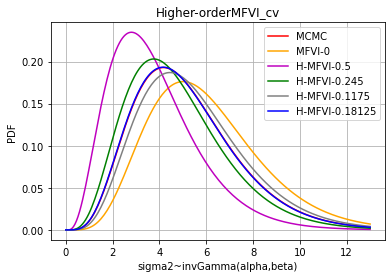

In [263]:
lambdaq1000 =[9.338450836788457, 0.40732306007522406, 5.1097020247483504, 16.182772292069075] #MCMC
lambdaq1000_1 =[9.38478842,  0.35433089,  5.95998952, 18.69864731] #theta = 0, ELBO = -27.73007764805573
lambdaq1000_2 =[9.43354726,  0.18043244,  3.71707765, 11.54137221] #0.5 ELBO = -27.78284445908103
lambdaq1000_3 =[9.44011225,  0.25273631,  4.6927932 , 15.53905912] #0.245 ELBO = -27.735300189796796
lambdaq1000_4 =[9.47717608,  0.32157296,  5.3870703 , 16.90887013] #0.1175, ELBO = -27.727253153837047
lambdaq1000_5 =[9.44017987,  0.31703348,  5.09259819, 16.07652511] #0.18175, ELBO = -27.71853326580989

x = np.linspace (0, 13, 200) 
plt.plot(x, st.gamma.pdf(x, a=lambdaq1000[2], loc=1/lambdaq1000[3]),"r",label="MCMC")
plt.plot(x, st.gamma.pdf(x, a=lambdaq1000_1[2], loc=1/lambdaq1000_1[3]),"orange",label="MFVI-0")
plt.plot(x, st.gamma.pdf(x, a=lambdaq1000_2[2], loc=1/lambdaq1000_2[3]),"m",label="H-MFVI-0.5")
plt.plot(x, st.gamma.pdf(x, a=lambdaq1000_3[2], loc=1/lambdaq1000_3[3]),"g",label="H-MFVI-0.245")
plt.plot(x, st.gamma.pdf(x, a=lambdaq1000_4[2], loc=1/lambdaq1000_4[3]),"grey",label="H-MFVI-0.1175")
plt.plot(x, st.gamma.pdf(x, a=lambdaq1000_5[2], loc=1/lambdaq1000_5[3]),"b",label="H-MFVI-0.18125")
plt.title('Higher-orderMFVI_cv') 
plt.xlabel('sigma2~invGamma(alpha,beta)')
plt.ylabel('PDF')
plt.legend()
plt.grid()
plt.show()
#run Gibbs Sampling time:  0:00:00.844915
#alpha_MCMC:  5.1097020247483504
#beta_MCMC:  16.182772292069075
#mu_MCMC:  9.338450836788457
#sigma2_MCMC:  0.40732306007522406

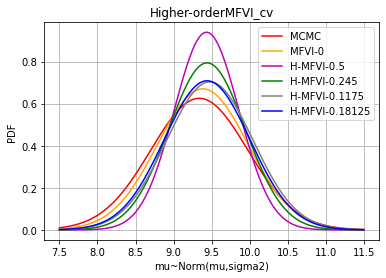

In [264]:
x = np.linspace(7.5, 11.5, 200)
plt.plot(x, st.norm.pdf(x, lambdaq1000[0], np.sqrt(lambdaq1000[1])),"r",label="MCMC")
plt.plot(x, st.norm.pdf(x, lambdaq1000_1[0], np.sqrt(lambdaq1000_1[1])),"orange",label="MFVI-0")
plt.plot(x, st.norm.pdf(x, lambdaq1000_2[0], np.sqrt(lambdaq1000_2[1])),"m",label="H-MFVI-0.5")
plt.plot(x, st.norm.pdf(x, lambdaq1000_3[0], np.sqrt(lambdaq1000_3[1])),"g",label="H-MFVI-0.245")
plt.plot(x, st.norm.pdf(x, lambdaq1000_4[0], np.sqrt(lambdaq1000_4[1])),"grey",label="H-MFVI-0.1175")
plt.plot(x, st.norm.pdf(x, lambdaq1000_5[0], np.sqrt(lambdaq1000_5[1])),"b",label="H-MFVI-0.18125")
plt.title('Higher-orderMFVI_cv') 
plt.xlabel('mu~Norm(mu,sigma2)')
plt.ylabel('PDF')
plt.legend()
plt.grid()
plt.show()